# Ghanaian Museum Suggestion Engine 

This is a suggestion engine for museums in Ghana in a bid to solve tourism problems.

#### Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')

Libraries imported.


#### Reading file

In [3]:
df = pd.read_csv('Museum.csv')
df

,Museums,Type,Region,Latitude,Longitude,Comment
0,Armed Forces Museum,Military,Kumasi,6.691367,-1.624872,The museum of military history in Ghana
1,Cape Coast Castle Museum,Ethnography and Archeology,Cape Coast,5.103600,-1.241400,Museum of ethnography and archeological histor...
2,Elmina Castle,History,Central Region,5.082600,-1.348100,Museum of history of the Gold Coast
3,Elmina Java Museum,History,Central Region,5.099500,-1.346800,"Museum containing history of Belanda Hitam, th..."
4,Fort Appollonia,History,Beyin,5.000000,-2.645000,Named on the day of Saint Appollonia which was...
5,Kwame Nkrumah Mausoleum,Tribute,Accra,5.544440,-0.202778,Dedicated to the former president as his body ...
6,Manhyia Palace,History,Kumasi,6.666667,-1.166670,Museum of history
7,Museum of Science and Technology,History,Accra,5.556761,0.206059,The museum containing the evolution of Science...
8,National Museum of Ghana,History,Accra,5.556667,-0.207780,Museum of historical evolution
9,Ussher Fort,Slave Trade,Accra,5.538500,0.208200,Museum showcasing the slave trade history in G...


## Visualization through mapping

Visualizing the map of Ghana and showing the museum points through points

In [6]:
# Ghana's latitude and longitude using Google search
ghn_lat = 6.6666
ghn_lng = -1.6163

ghn_map = folium.Map(location = [ghn_lat,ghn_lng], zoom_start = 6.4)


# add markers to map
for lat, lng, borough, neighborhood, comment in zip(df['Latitude'], df['Longitude'], df['Region'], df['Museums'], df['Comment']):
    label = '{}, {}, {}'.format(neighborhood, borough, comment)
    html = """ 
        <!doctype html>
        <html>
        <img src="2.jpg">
        </html>"""




    iframe = folium.IFrame(html=html,width=0.5,height=0.6)
    label = folium.Popup(label,iframe)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(ghn_map)
    
    
    
ghn_map

## API calls through Foursquare

Using the Foursquare places API to call the places near these museums. These places includes restaurants, shopping malls and hotels

In [7]:
CLIENT_ID = '04PMWUVRTG4IIJTJGZEXF55GOEZUSHJE2WQOIO32WPKZVHTW'
CLIENT_SECRET = 'RK5LU4ZOWDFSV5NOFOC1UBIUSVK3PSNGYNUHPHSEHN1CC3EZ' 
VERSION = '20180605'

In [8]:
latitude_scar = 6.6666
longitude_scar = -1.6163

In [9]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_scar, longitude_scar, VERSION, radius, LIMIT)

In [10]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5febe2b1dad389062d50d689'},
 'response': {'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 6.671100004500004,
    'lng': -1.6117778207760303},
   'sw': {'lat': 6.662099995499996, 'lng': -1.6208221792239699}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e83b118dab4c2205b8dd107',
       'name': 'Royal Park Hotel & Chinese Restaurant',
       'location': {'lat': 6.669464663886983,
        'lng': -1.6172490562625617,
        'labeledLatLngs': [{'label': 'display',
          'lat': 6.669464663886983,
          'lng': -1.6172490562625617}],
        'distance': 335,
        'cc': 'GH',
        'city': 'Kuma

#### Categorizing the results

In [11]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']  
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

<ipython-input-12-9d4491af7edd>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Royal Park Hotel & Chinese Restaurant,Chinese Restaurant,6.669465,-1.617249
1,Piri Piri Fast Food,American Restaurant,6.666199,-1.617170
2,Noble House Chinese and Indian Restaurant,Chinese Restaurant,6.670509,-1.616401
3,Royal Park Rest.,Chinese Restaurant,6.664637,-1.617799
4,Royal Park Hotel & Restaurant,Hotel,6.664598,-1.617973
5,Ahodwo Roundabout,Intersection,6.669084,-1.617273
6,Hotel Georgia,Hotel,6.669435,-1.615870
7,Echoes spot,African Restaurant,6.664010,-1.617899


#### Getting nearby venues from the categories gotten

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
nearby_venues

,name,categories,lat,lng
0,Royal Park Hotel & Chinese Restaurant,Chinese Restaurant,6.669465,-1.617249
1,Piri Piri Fast Food,American Restaurant,6.666199,-1.617170
2,Noble House Chinese and Indian Restaurant,Chinese Restaurant,6.670509,-1.616401
3,Royal Park Rest.,Chinese Restaurant,6.664637,-1.617799
4,Royal Park Hotel & Restaurant,Hotel,6.664598,-1.617973
5,Ahodwo Roundabout,Intersection,6.669084,-1.617273
6,Hotel Georgia,Hotel,6.669435,-1.615870
7,Echoes spot,African Restaurant,6.664010,-1.617899


#### Returning a list of the museums

In [15]:
museums = getNearbyVenues(names=df['Museums'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Armed Forces Museum
Cape Coast Castle Museum
Elmina Castle
Elmina Java Museum
Fort Appollonia
Kwame Nkrumah Mausoleum
Manhyia Palace
Museum of Science and Technology
National Museum of Ghana
Ussher Fort
Volta Regional Museum
Nurom Hat Museum
Gramophone Records Museum


#### Merging the museums with nearby venues

In [16]:
museums.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Armed Forces Museum,6.691367,-1.624872,Ababio Express,6.690813,-1.624448,Grocery Store
1,Armed Forces Museum,6.691367,-1.624872,Baboo Cafeteria,6.690505,-1.622666,Café
2,Armed Forces Museum,6.691367,-1.624872,Ultimate fashions,6.695000,-1.623102,Boutique
3,Armed Forces Museum,6.691367,-1.624872,Apple Store Ksi,6.694001,-1.621618,Department Store
4,Armed Forces Museum,6.691367,-1.624872,Paul Sagoe Lane,6.693306,-1.620945,Shopping Mall


## One Hot Encoding

In [17]:
# one hot encoding
museum_ven = pd.get_dummies(museums[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
museum_ven['Neighborhood'] = museums['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [museum_ven.columns[-1]] + list(museum_ven.columns[:-1])
museum_ven = museum_ven[fixed_columns]

museum_ven.head()

,Neighborhood,African Restaurant,Art Gallery,Boat or Ferry,Boutique,Bus Station,Café,Candy Store,Convenience Store,Department Store,Fast Food Restaurant,Flea Market,Gaming Cafe,Grocery Store,Gym / Fitness Center,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Indian Restaurant,Liquor Store,Paper / Office Supplies Store,Park,Resort,Science Museum,Sculpture Garden,Shopping Mall,Tourist Information Center,Vegetarian / Vegan Restaurant
0,Armed Forces Museum,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Armed Forces Museum,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Armed Forces Museum,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Armed Forces Museum,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Armed Forces Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
scarb_grouped = museum_ven.groupby('Neighborhood').mean().reset_index()
scarb_grouped.head(10)

,Neighborhood,African Restaurant,Art Gallery,Boat or Ferry,Boutique,Bus Station,Café,Candy Store,Convenience Store,Department Store,Fast Food Restaurant,Flea Market,Gaming Cafe,Grocery Store,Gym / Fitness Center,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Indian Restaurant,Liquor Store,Paper / Office Supplies Store,Park,Resort,Science Museum,Sculpture Garden,Shopping Mall,Tourist Information Center,Vegetarian / Vegan Restaurant
0,Armed Forces Museum,0.000000,0.00,0.00,0.2,0.0,0.2,0.0,0.0,0.200000,0.0,0.00,0.0,0.2,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.2,0.000000,0.000000
1,Cape Coast Castle Museum,0.166667,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.166667,0.333333
2,Elmina Castle,0.000000,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,0.25,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,Elmina Java Museum,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.5,0.0,0.0,0.00,0.0,0.5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,Gramophone Records Museum,0.000000,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5,Kwame Nkrumah Mausoleum,0.200000,0.00,0.00,0.0,0.0,0.0,0.2,0.2,0.000000,0.0,0.20,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.2,0.000000,0.0,0.000000,0.0,0.000000,0.000000
6,National Museum of Ghana,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.00,0.2,0.0,0.000000,0.000000,0.2,0.0,0.2,0.0,0.000000,0.4,0.000000,0.0,0.000000,0.000000
7,Nurom Hat Museum,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.000000
8,Volta Regional Museum,0.200000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.2,0.00,0.0,0.0,0.2,0.00,0.2,0.0,0.000000,0.000000,0.0,0.2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


#### Clustering the neighborhood through K-Means

In [23]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

museum_clust = scarb_grouped.drop('Neighborhood',1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(museum_clust)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
#len(kmeans.labels_)#=16
#scarborough_data.shape

array([1, 1, 1, 0, 2, 1, 1, 1, 1], dtype=int32)

In [22]:
museums

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Armed Forces Museum,6.691367,-1.624872,Ababio Express,6.690813,-1.624448,Grocery Store
1,Armed Forces Museum,6.691367,-1.624872,Baboo Cafeteria,6.690505,-1.622666,Café
2,Armed Forces Museum,6.691367,-1.624872,Ultimate fashions,6.695000,-1.623102,Boutique
3,Armed Forces Museum,6.691367,-1.624872,Apple Store Ksi,6.694001,-1.621618,Department Store
4,Armed Forces Museum,6.691367,-1.624872,Paul Sagoe Lane,6.693306,-1.620945,Shopping Mall
5,Cape Coast Castle Museum,5.103600,-1.241400,Cape Coast Castle,5.103548,-1.240991,Tourist Information Center
6,Cape Coast Castle Museum,5.103600,-1.241400,Oasis Beach Resort,5.103258,-1.243880,Resort
7,Cape Coast Castle Museum,5.103600,-1.241400,Cape Coast Castle Restaurant,5.103471,-1.241924,African Restaurant
8,Cape Coast Castle Museum,5.103600,-1.241400,Baobab Vegetarian Bar,5.105170,-1.241181,Vegetarian / Vegan Restaurant
9,Cape Coast Castle Museum,5.103600,-1.241400,Emperor Ital Joint,5.103945,-1.243076,Vegetarian / Vegan Restaurant


#### Map plotting using matplotlib

In [25]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, ven, vc in zip(museums['Venue Latitude'], museums['Venue Longitude'], museums['Venue'], museums['Venue Category']):
    html = '<img src="image.png" style="width:400px;height:300px;">'
    label = folium.Popup( str(ven) +  str(vc),parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(ghn_map)
       
ghn_map

# A Highlight of Ghanaian Museum Suggestion Engine

### Ghana is a country along the Gulf of Guinea and the Atlantic Ocean, in the subregion of West Africa. Spanning a land mass of 238,535 km2 (92,099 sq mi), Ghana is bordered by the Ivory Coast in the west, Burkina Faso in the north, Togo in the east, the Gulf of Guinea and the Atlantic Ocean in the south. Ghana means "Warrior King" in the Soninke language.

#### Ghana has so many attraction sites with museums inclusive and this project focuses on only 14 museums.

###### Categories includes:

Military
History
Music
Hats
Slave Trade
Tribute 
Ethnography
Archeology

Pick a category: Military, Ethnography, Archeology, History, Tribute, Slave Trade, Hat, MusicHistory


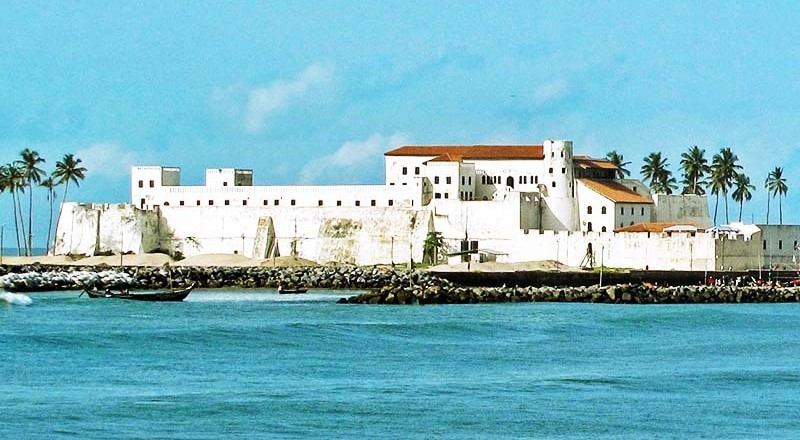

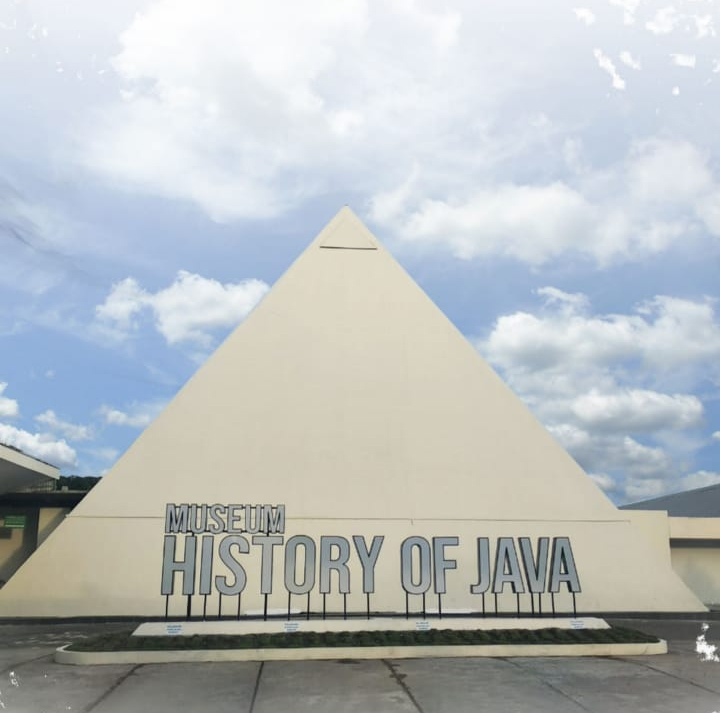

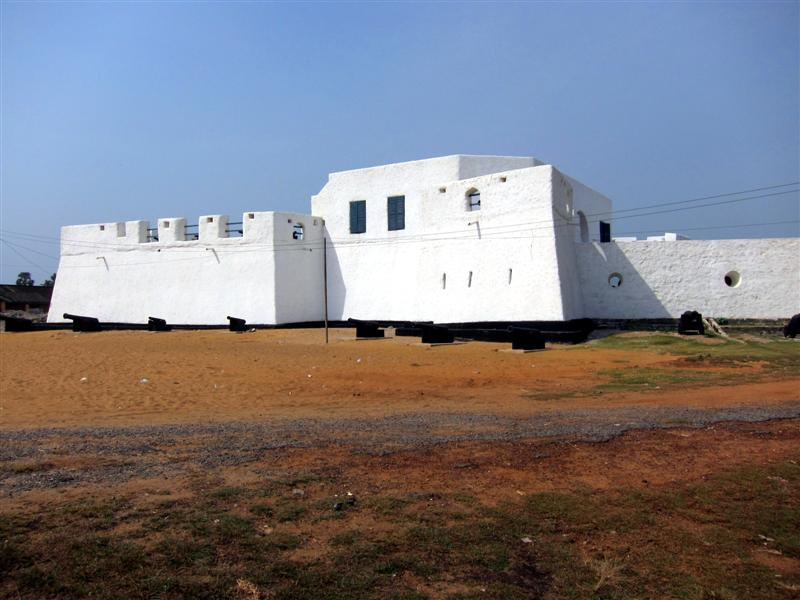

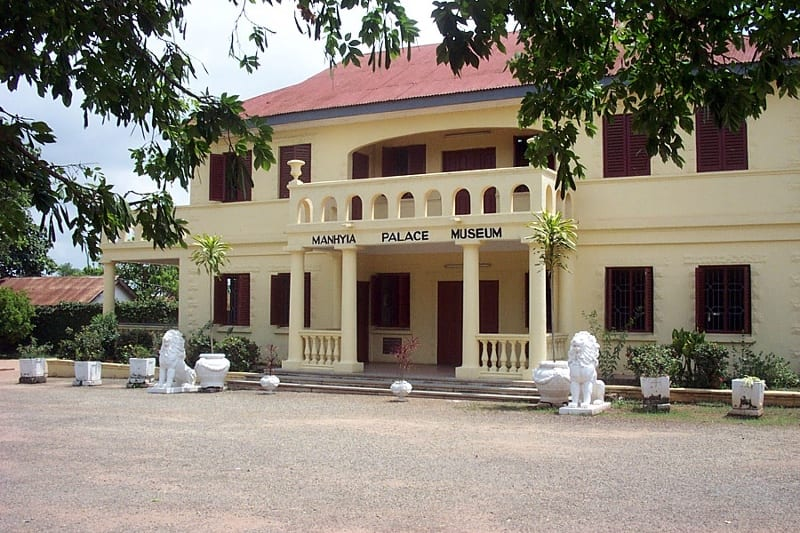

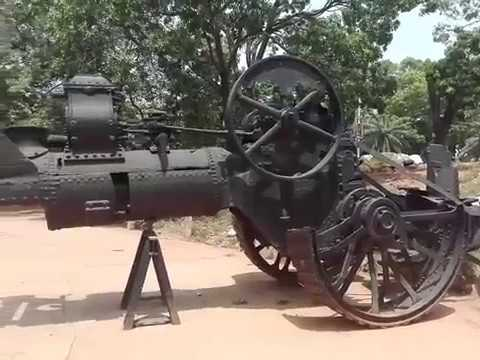

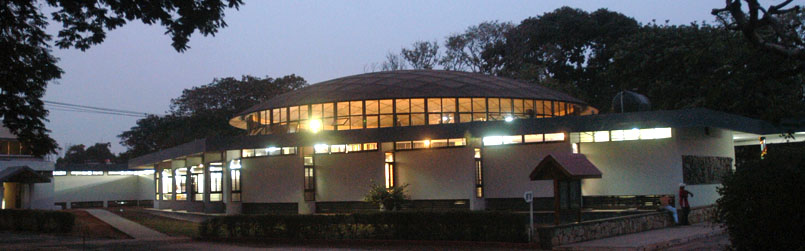

2                       Elmina Castle
3                  Elmina Java Museum
4                     Fort Appollonia
6                      Manhyia Palace
7    Museum of Science and Technology
8            National Museum of Ghana
Name: Museums, dtype: object


In [29]:
from IPython.display import Image, display
user = str(input("Pick a category: Military, Ethnography, Archeology, History, Tribute, Slave Trade, Hat, Music"))

ghn_lat = 6.6666; ghn_lng = -1.6163
ghn_map = folium.Map(location = [ghn_lat,ghn_lng], zoom_start = 6.4)
    
df2 = df.loc[df['Type'] == user]

dict2= {"Military" : ['arm.jpg'], "Ethnography": ['castle.jpeg','volta.jpg'], "History":['elmina.jpg', 'java.jpg', 'appollonia.jpg', 'manhyia.jpg', 'museum.jpg', 'national.jpg'],
        "Music": ['gramophone.jpg'], "Hats":[], "Tribute":['kwame.jpg'], "Archeology":['castle.jpeg'],
        "Slave Trade": ['ussher.jpg']}
# add markers to map
for lat, lng, borough, neighborhood, comments in zip(df2['Latitude'], df2['Longitude'], df2['Region'], df2['Museums'],  df2['Comment']):
    label = '{}, {}, {}'.format(neighborhood, borough, comments)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(ghn_map)
           

for imageName in dict2[user]:
    display(Image(filename=imageName))



print(df2['Museums'])
ghn_map